In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import autosklearn.regression
import sklearn
import matplotlib.pyplot as plt
import joblib
import math
import time
from IPython.display import display
from nextorch import plotting, bo, doe, io

In [2]:
# Train the flow reaction model for yield and selectivity prediction from scratch
DATA_PATH = Path("../data/moo")
TRAIN = DATA_PATH / "train.csv"
TEST = DATA_PATH / "test.csv"
dataset_name = "flow"

def load_data(path: Path) -> tuple:
    df = pd.read_csv(path)
    X = df.drop(["yield", "selectivity"], axis=1).to_numpy()
    y = df[["yield", "selectivity"]].to_numpy()
    return df, X, y

df_train, X_train, y_train = load_data(TRAIN)
df_test, X_test, y_test = load_data(TEST)

In [3]:
# Inspect the input data
df = pd.concat([df_train, df_test])
print(len(df))
df.head()

30


,m_B,t_RT1,T_drawH,m_C,t_RT2,T_methyl,yield,selectivity
0,2.66,8.45,-39.0,3.15,121.20,-30,54.65,90.57
1,2.65,4.23,-39.0,3.15,121.20,-30,74.50,86.99
2,2.66,2.07,-39.0,3.15,121.20,-30,72.93,84.90
3,3.13,3.70,-39.0,3.15,121.20,-30,71.73,80.67
4,2.07,9.14,-34.0,0.71,8.64,-35,24.49,52.03


In [4]:
# Set the operating range for each parameter
X_ranges = []
# Set the reponse range
Y_plot_range = []

for column in df.columns:
    num = len(df)
    max_value = df[column].max()
    min_value = df[column].min()
    data_range = max_value - min_value
    print(f"ColName: {column}")
    print(f"Max value: {max_value}, Recommendation: {math.ceil(max_value)}")
    print(f"Min value: {min_value}, Recommendation: {math.floor(min_value)}")
    print(f"Range: {data_range}, Recommendation: {data_range / num}")
    print("------------------------")
    # Excludes traget
    if column == "yield" or column == "impurity":
        Y_plot_range.extend([0, 100])
    else:
        X_ranges.append([min_value, max_value])

ColName: m_B
Max value: 3.13, Recommendation: 4
Min value: 2.07, Recommendation: 2
Range: 1.06, Recommendation: 0.035333333333333335
------------------------
ColName: t_RT1
Max value: 36.57, Recommendation: 37
Min value: 2.07, Recommendation: 2
Range: 34.5, Recommendation: 1.15
------------------------
ColName: T_drawH
Max value: -17.3, Recommendation: -17
Min value: -49.0, Recommendation: -49
Range: 31.7, Recommendation: 1.0566666666666666
------------------------
ColName: m_C
Max value: 3.15, Recommendation: 4
Min value: 0.71, Recommendation: 0
Range: 2.44, Recommendation: 0.08133333333333333
------------------------
ColName: t_RT2
Max value: 278.6, Recommendation: 279
Min value: 3.85, Recommendation: 3
Range: 274.75, Recommendation: 9.158333333333333
------------------------
ColName: T_methyl
Max value: -12, Recommendation: -12
Min value: -41, Recommendation: -41
Range: 29, Recommendation: 0.9666666666666667
------------------------
ColName: yield
Max value: 87.69, Recommendation: 8

In [5]:
# Auto-sklearn model
model_path = Path("../model/autosklearn/")
model_path.mkdir(exist_ok=True, parents=True)

rerun = False

if rerun:
    automl = autosklearn.regression.AutoSklearnRegressor(
        time_left_for_this_task=240,
        per_run_time_limit=30,
    )
    automl.fit(X_train, y_train, dataset_name=dataset_name)
    joblib.dump(automl, model_path / "auto-sklearn_reg_moo.pkl")
else:
    automl = joblib.load(model_path / "auto-sklearn_reg_moo.pkl")
    print(automl.predict(X_train))  # Print some prediction for X_train

          rank  ensemble_weight                 type      cost  duration
model_id                                                                
35           1             0.32  k_nearest_neighbors  0.533588  0.350071
109          2             0.28  k_nearest_neighbors  0.596065  0.285483
8            3             0.40        decision_tree  0.616681  0.297004
Train R2 score: 0.9175561244484651
Test R2 score: 0.9465631225340403


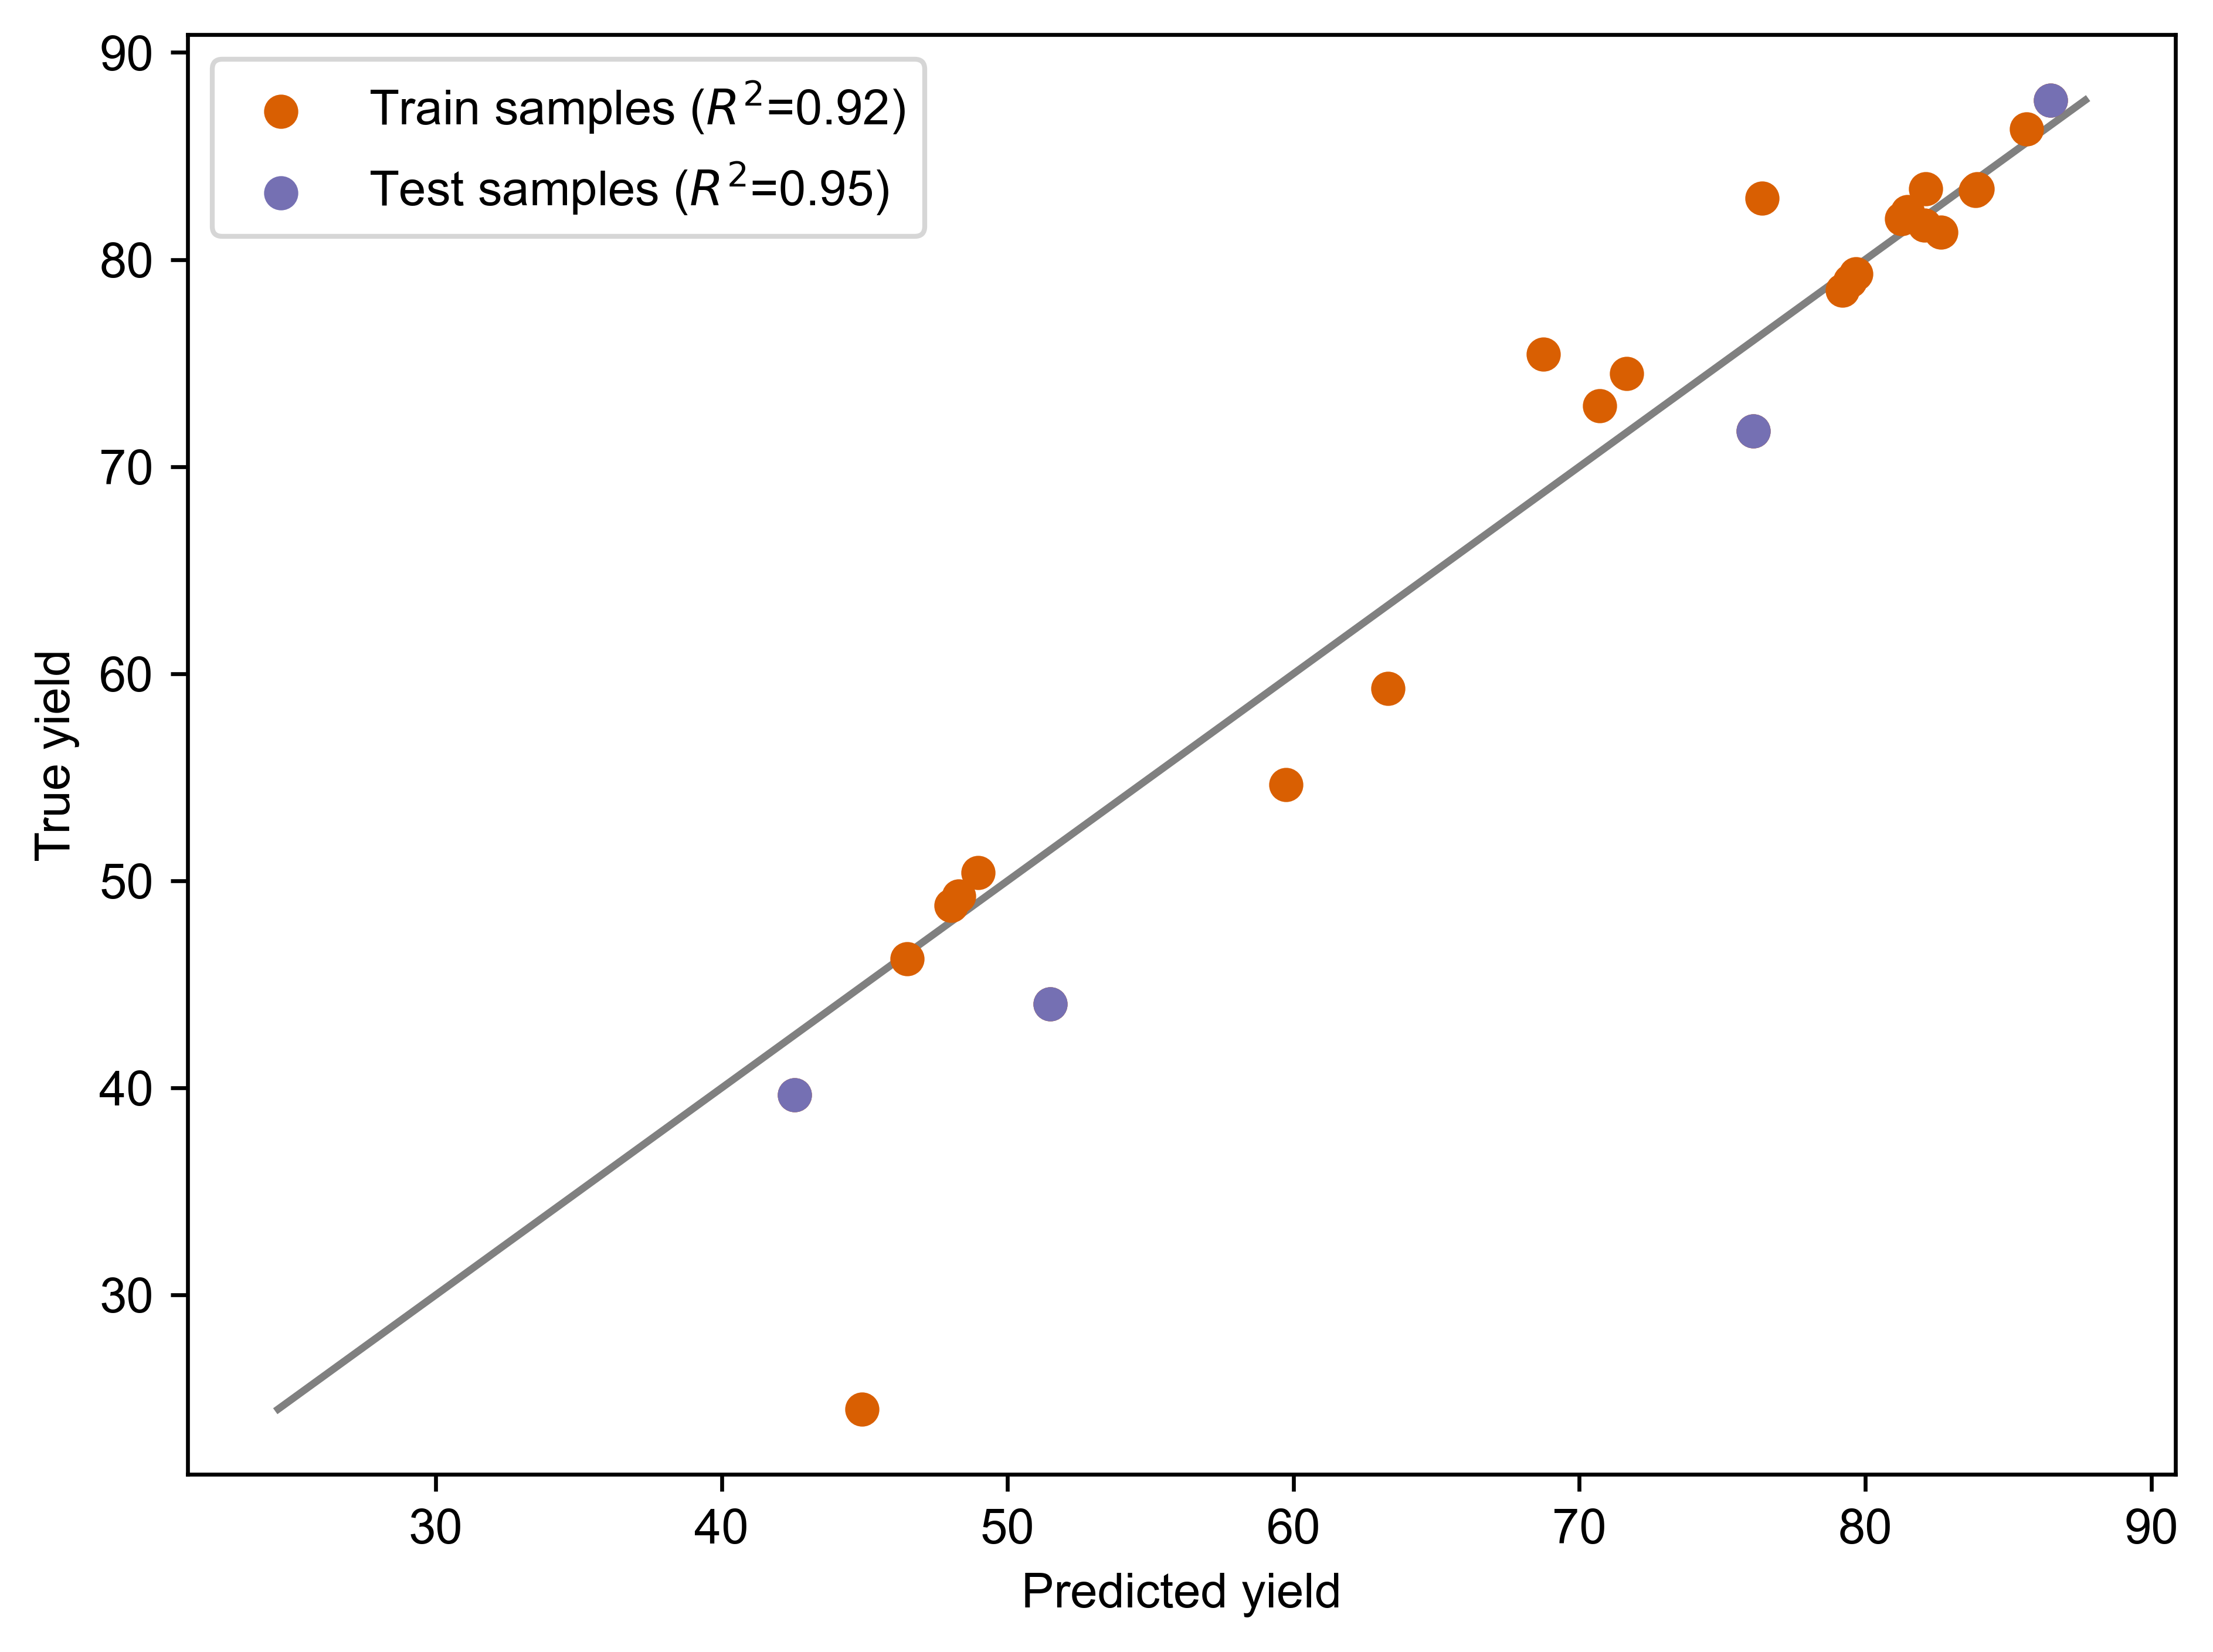

Train R2 score: 0.5225489088641639
Test R2 score: 0.428998692175365


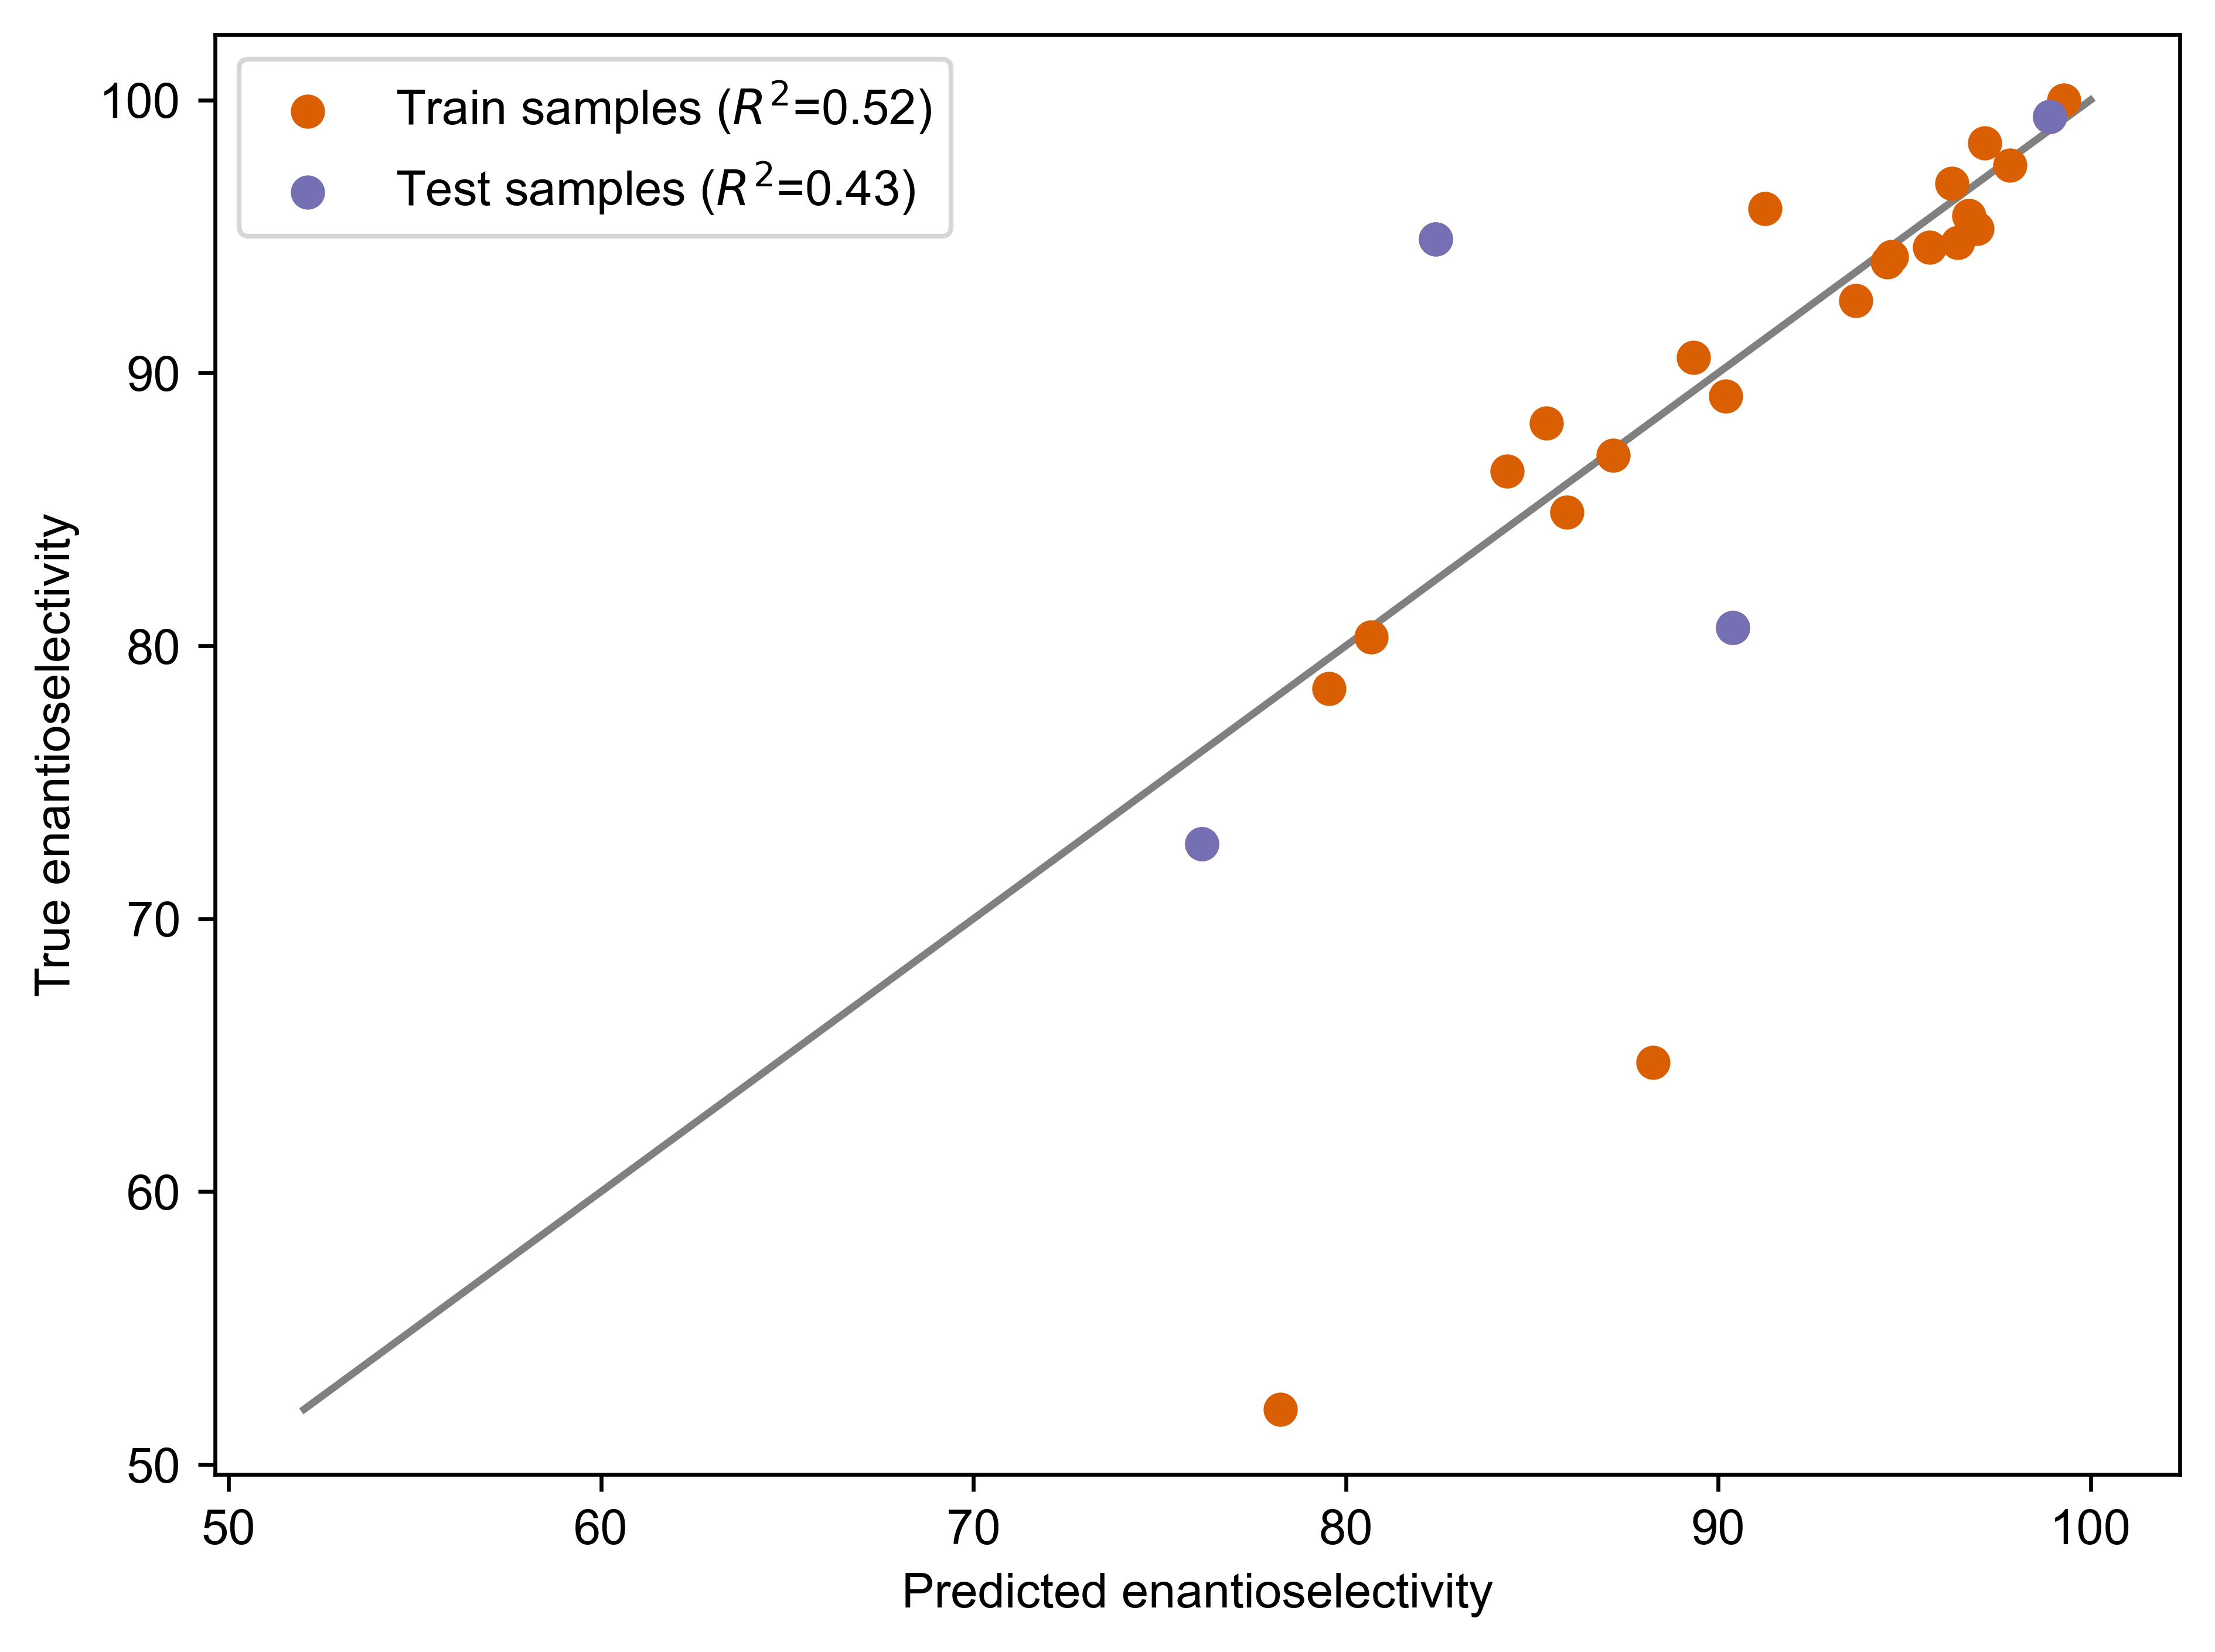

In [6]:
print(automl.leaderboard())

_train_predictions = automl.predict(X_train)
_test_predictions = automl.predict(X_test)

_y_train = y_train
_y_test = y_test

# Plotting
plt.rcParams["font.family"] = "arial"
plt.rcParams['figure.dpi'] = 600

# Get the score of final ensemble
# Yield
i = 0
train_predictions = _train_predictions[:, i]
test_predictions = _test_predictions[:, i]
y_train = _y_train[:, i]
y_test = _y_test[:, i]

print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
plt.scatter(train_predictions, y_train, label="Train samples ($R^2$=0.92)", c="#d95f02")
plt.scatter(test_predictions, y_test, label="Test samples ($R^2$=0.95)", c="#7570b3")
plt.xlabel("Predicted yield")
plt.ylabel("True yield")
plt.legend()
plt.plot(c="k", zorder=0)
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         c="grey", zorder=0)
plt.tight_layout()
plt.show()

# Selectivity
i = 1
train_predictions = _train_predictions[:, i]
test_predictions = _test_predictions[:, i]
y_train = _y_train[:, i]
y_test = _y_test[:, i]

print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
plt.scatter(train_predictions, y_train, label="Train samples ($R^2$=0.52)", c="#d95f02")
plt.scatter(test_predictions, y_test, label="Test samples ($R^2$=0.43)", c="#7570b3")
plt.xlabel("Predicted enantioselectivity")
plt.ylabel("True enantioselectivity")
plt.legend()
plt.plot(c="k", zorder=0)
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         c="grey", zorder=0)
plt.tight_layout()
plt.show()

# restore
y_train = _y_train
y_test = _y_test

In [7]:
# Define the objective function
def Reactor(X_real):
    Y_real = automl.predict(X_real)
    return Y_real  # yield and selectivity

In [8]:
# Objective function
objective_func = Reactor

# Define the design space
# Three input temperature C, pH, log10(residence time)
x_name_simple = df.columns[:-2]
X_name_list = x_name_simple
X_units = ["" for i in range(len(x_name_simple))]

# Add the units
X_name_with_unit = []
for i, var in enumerate(X_name_list):
    if not X_units[i] == "":
        var = var + " (" + X_units[i] + ")"
    X_name_with_unit.append(var)

# two outputs
Y_name_with_unit = ["Yield(%)", "Enantioselectivity(%)"]

# combine X and Y names
var_names = X_name_with_unit + Y_name_with_unit

# Get the information of the design space
n_dim = len(X_name_list)  # the dimension of inputs
n_objective = len(Y_name_with_unit)  # the dimension of outputs

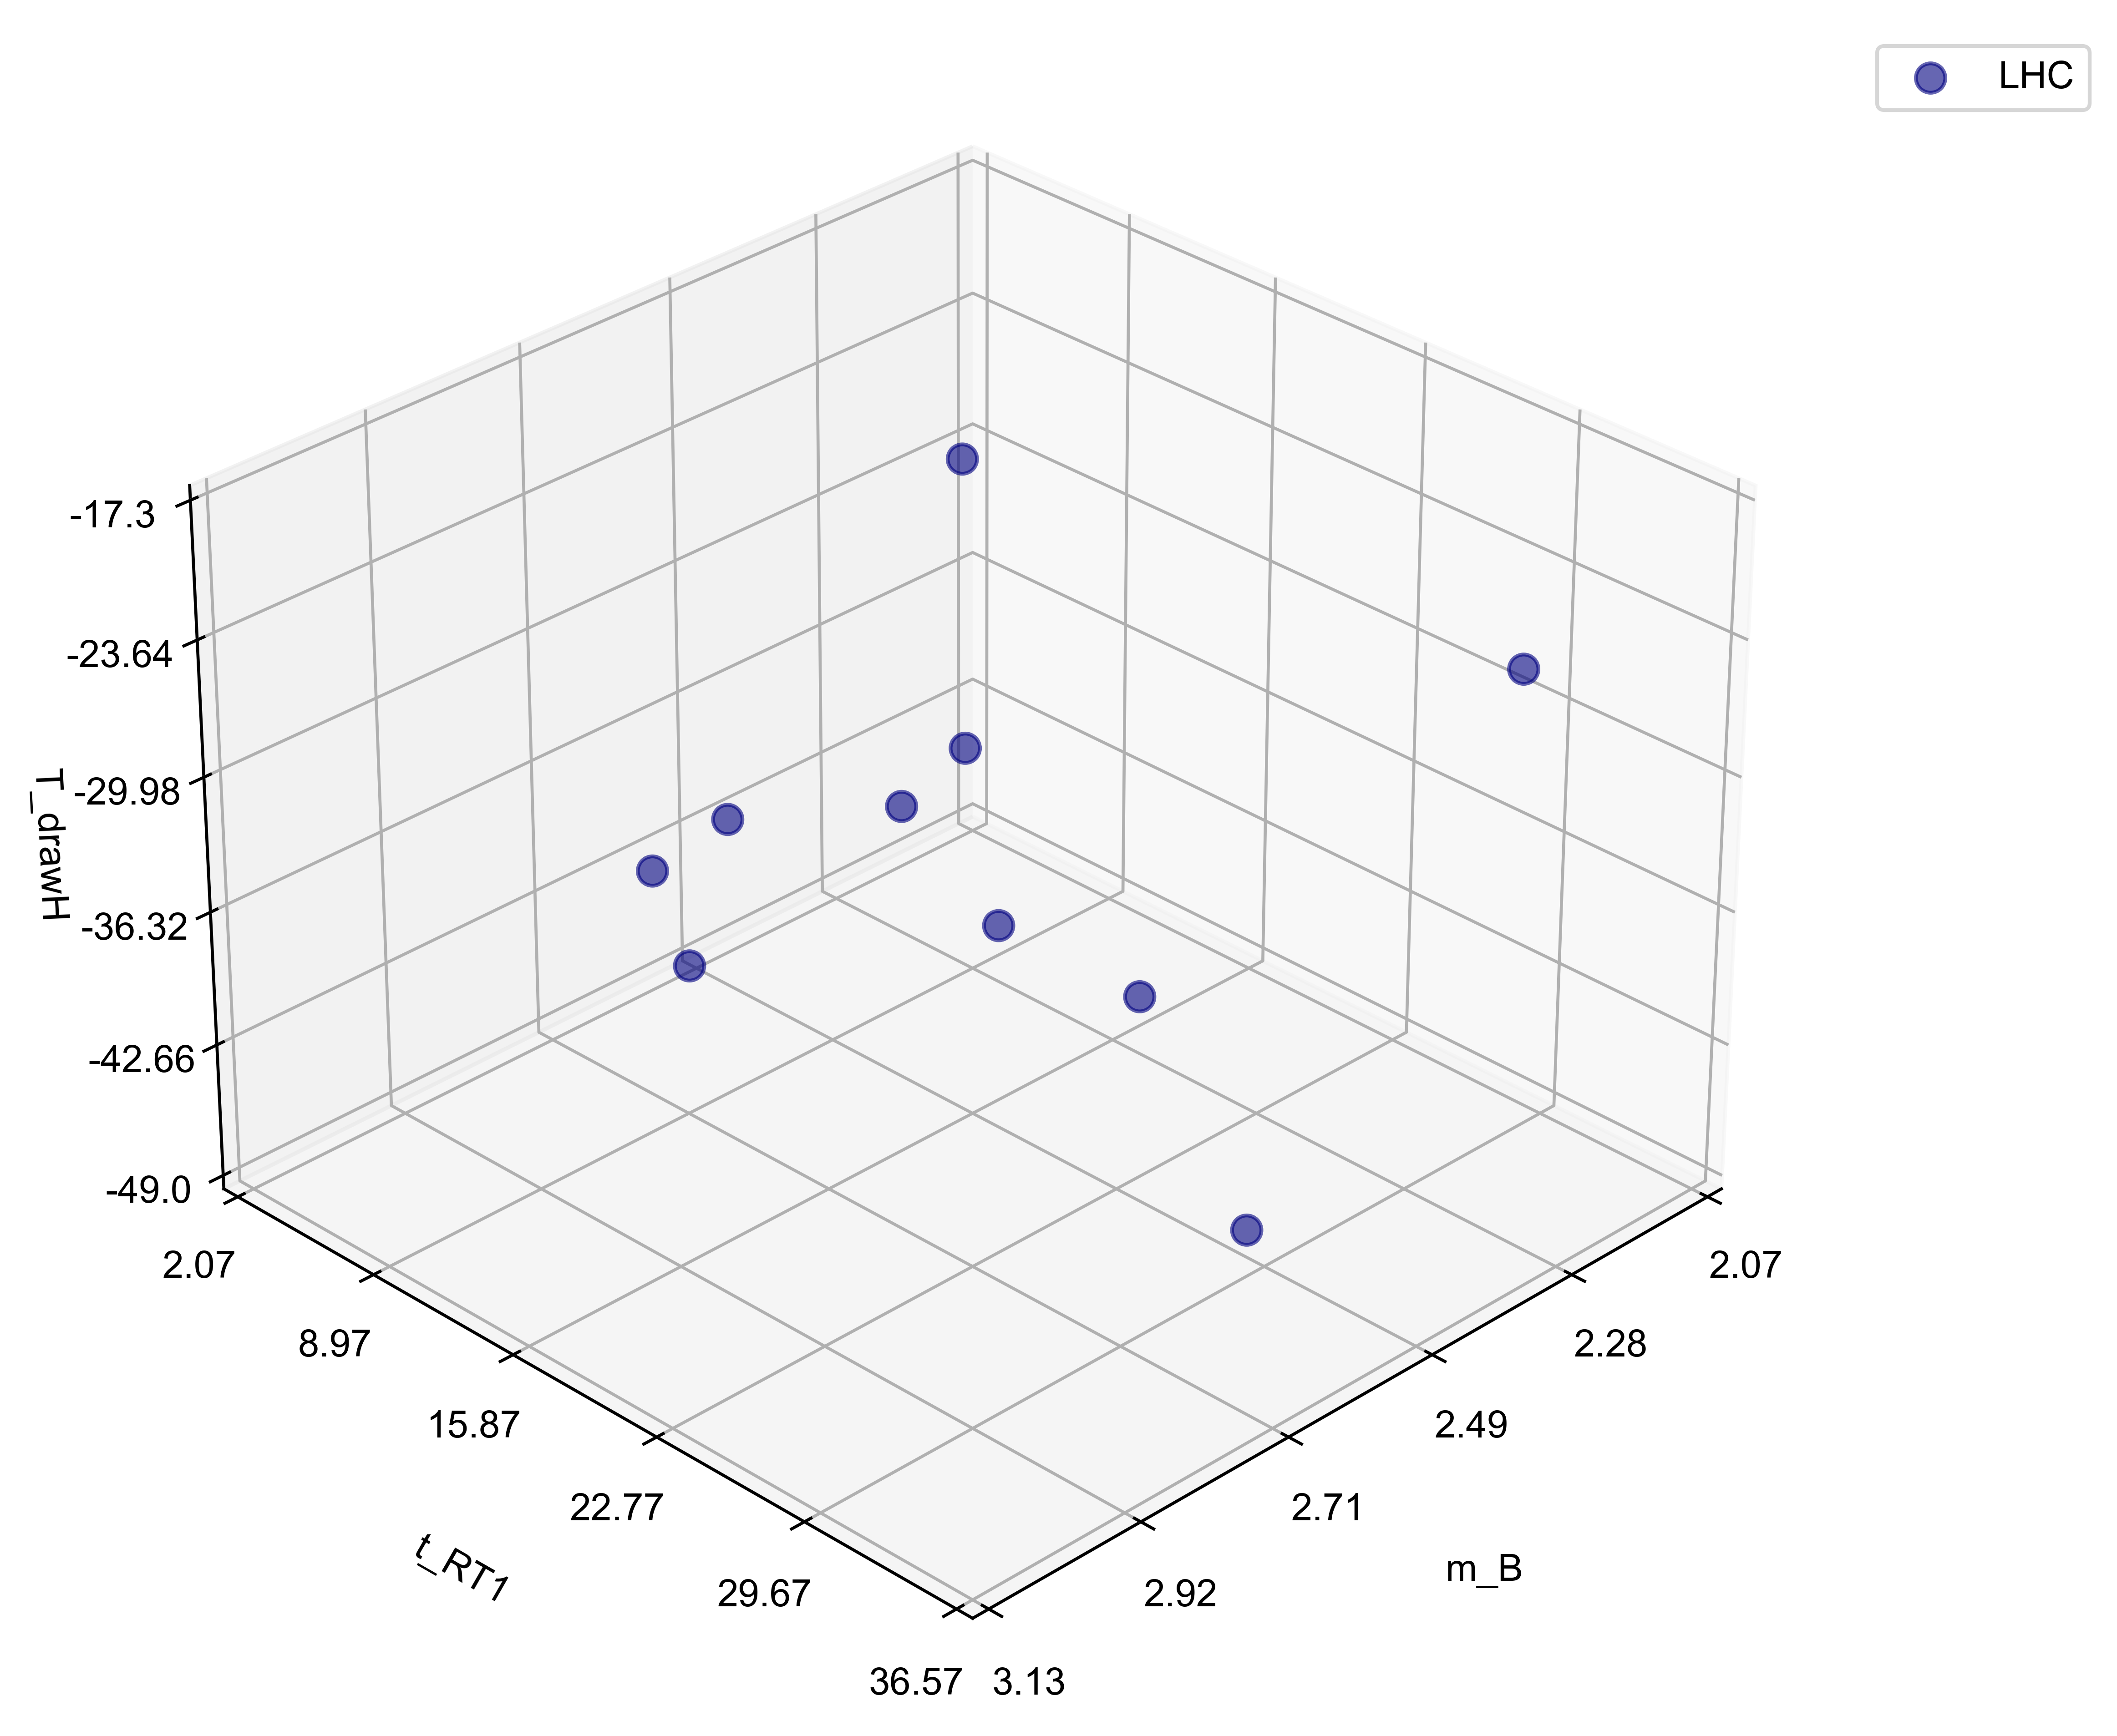

In [9]:
# Initial Sampling
# Latin hypercube design with 10 initial points
n_init_lhc = 10
X_init_lhc = doe.latin_hypercube(n_dim=n_dim, n_points=n_init_lhc, seed=42)
# Get the initial responses
Y_init_lhc = bo.eval_objective_func(X_init_lhc, X_ranges, objective_func)

# Compare the two sampling plans
plotting.sampling_3d(
    X_init_lhc, X_names=X_name_with_unit, X_ranges=X_ranges, design_names="LHC"
)

In [10]:
# Initialize an multi-objective Experiment object
# Set its name, the files will be saved under the folder with the same name
Exp_lhc = bo.WeightedMOOExperiment("yield_MOO")
# Import the initial data
Exp_lhc.input_data(
    X_init_lhc,
    Y_init_lhc,
    X_ranges=X_ranges,
    X_names=X_name_with_unit,
    Y_names=Y_name_with_unit,
    unit_flag=True,
)

# Set the optimization specifications
# here we set the objective function, minimization by default
# 10 weights, 10 Experiments
n_exp = 30  # number of single Experiments

# Set a weight vector for objective 1
weights_obj_1 = np.linspace(0, 1, n_exp)
weights_obj_2 = 1 - weights_obj_1

# Set a timer
start_time = time.time()
Exp_lhc.set_optim_specs(
    objective_func=objective_func, maximize=True, weights=weights_obj_1
)
end_time = time.time()
print(
    "Initializing {} Experiments takes {:.2f} minutes.".format(
        n_exp, (end_time - start_time) / 60
    )
)

Initializing 30 experiments
Iter 10/100: 4.232306480407715
Iter 20/100: 3.9035096168518066
Iter 30/100: 3.807821750640869
Iter 40/100: 3.755833387374878
Iter 50/100: 3.745217800140381


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541035/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2115.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Iter 60/100: 3.737717628479004
Initializing experiments 3.33 % 
Iter 10/100: 4.232306480407715
Iter 20/100: 3.9035096168518066
Iter 30/100: 3.807821750640869
Iter 40/100: 3.755833387374878
Iter 50/100: 3.745217800140381
Iter 60/100: 3.737717628479004
Initializing experiments 6.67 % 
Iter 10/100: 4.232306480407715
Iter 20/100: 3.9035096168518066
Iter 30/100: 3.807821750640869
Iter 40/100: 3.755833387374878
Iter 50/100: 3.745217800140381
Iter 60/100: 3.737717628479004
Initializing experiments 10.00 % 
Iter 10/100: 4.232306480407715
Iter 20/100: 3.9035096168518066
Iter 30/100: 3.807821750640869
Iter 40/100: 3.755833387374878
Iter 50/100: 3.745217800140381
Iter 60/100: 3.737717628479004
Initializing experiments 13.33 % 
Iter 10/100: 4.232306480407715
Iter 20/100: 3.9035096168518066
Iter 30/100: 3.807821750640869
Iter 40/100: 3.755833387374878
Iter 50/100: 3.745217800140381
Iter 60/100: 3.737717628479004
Initializing experiments 16.67 % 
Iter 10/100: 4.232306480407715
Iter 20/100: 3.9035096

In [11]:
# Set the number of iterations for each experiments
n_trials_lhc = 30
# Set a timer
start_time = time.time()
Exp_lhc.run_exp_auto(n_trials_lhc)

end_time = time.time()
print(
    "Optimizing {} Experiments takes {:.2f} minutes.".format(
        n_exp, (end_time - start_time) / 60
    )
)

Running 30 experiments


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5407910346984863


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3260951042175293


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.1726016998291016


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.0009589195251465


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8633809089660645


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.7363767623901367


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8132097721099854


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.7338364124298096


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.583217144012451


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.456759452819824


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.3486385345458984


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.254241466522217


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1381149291992188


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0332279205322266


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.94732666015625


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4547555446624756
Iter 20/100: 1.23944890499115
Iter 30/100: 1.1676933765411377
Iter 40/100: 1.1536617279052734
Iter 50/100: 1.1533589363098145
Iter 60/100: 1.1515886783599854
Iter 70/100: 1.1513381004333496
Iter 80/100: 1.1511108875274658


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0631942749023438
Iter 20/100: 1.0615897178649902


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2344167232513428


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9703450202941895
Iter 20/100: 1.9085720777511597
Iter 30/100: 1.868693232536316
Iter 40/100: 1.9088325500488281


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9813923835754395


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9177285432815552


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8065922260284424


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6876411437988281


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2969262599945068
Iter 20/100: 1.0540242195129395
Iter 30/100: 1.0265166759490967
Iter 40/100: 1.0240929126739502
Iter 50/100: 1.0216262340545654
Iter 60/100: 1.0205507278442383
Iter 70/100: 1.020320177078247


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9666100740432739
Iter 20/100: 0.9660316705703735


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9075124263763428
Iter 20/100: 0.9067041873931885
Iter 30/100: 0.9065108895301819


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9688327312469482


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5611730813980103


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4382292032241821


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6189080476760864
Running experiments 3.33 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5406675338745117


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.342684268951416


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.162914752960205


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.0041215419769287


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.858954429626465


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8475089073181152
Iter 20/100: 2.816084861755371


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.796191692352295


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.5959954261779785


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.498657703399658


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.391599178314209


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.278156280517578


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.14505672454834


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1651077270507812


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.994093894958496


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.953436017036438


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8238297700881958


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3268625736236572
Iter 20/100: 1.119531273841858


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3463306427001953


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.036458134651184
Iter 20/100: 0.9906225204467773


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1134668588638306


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.42743366956710815


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.3747444152832031


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.2623966634273529


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.12141509354114532
Iter 20/100: 0.12026190757751465


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.077977254986763
Iter 20/100: 0.07722710072994232
Iter 30/100: 0.07714976370334625
Iter 40/100: 0.07709570229053497


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.009848425164818764
Iter 20/100: 0.009368343278765678
Iter 30/100: 0.009219219908118248
Iter 40/100: 0.009118568152189255


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7867217063903809


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.20205947756767273
Iter 20/100: 0.14666292071342468
Iter 30/100: 0.14366599917411804
Iter 40/100: 0.1396668553352356
Iter 50/100: 0.13862597942352295
Iter 60/100: 0.1381884217262268
Iter 70/100: 0.13795703649520874
Iter 80/100: 0.13792553544044495


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.10014474391937256
Iter 20/100: 0.09867125749588013
Iter 30/100: 0.09829504787921906
Iter 40/100: 0.09808322787284851
Iter 50/100: 0.09800384938716888
Iter 60/100: 0.09797991812229156


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.018792128190398216
Iter 20/100: 0.017940664663910866
Iter 30/100: 0.01765371486544609
Iter 40/100: 0.017584389075636864
Iter 50/100: 0.01753813959658146
Running experiments 6.67 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5404505729675293


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3381588459014893


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.1576967239379883


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.999387502670288


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.854362726211548


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8590502738952637


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8095040321350098


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.5157952308654785


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.551480293273926


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.384906530380249


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2927017211914062


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.171475410461426


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.07615327835083


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9430564641952515


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8816967010498047


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6976432800292969


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6972626447677612


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1912719011306763
Iter 20/100: 0.8803057670593262
Iter 30/100: 0.8695113062858582


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8240724802017212
Iter 20/100: 0.8235848546028137
Iter 30/100: 0.8234536647796631


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9323084354400635


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2095519304275513


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4803006649017334


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6485832929611206


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4725141525268555


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 0.5767014026641846
Iter 10/100: 1.0967618227005005


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: -0.03423182666301727


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: -0.19577208161354065
Iter 20/100: -0.20089241862297058
Iter 30/100: -0.20249977707862854
Iter 40/100: -0.2029343545436859
Iter 50/100: -0.2032044529914856


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.23200958967208862


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: -0.2533310055732727
Running experiments 10.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.540261745452881


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.333911895751953


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.1525049209594727


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.9918832778930664


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8508663177490234


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.716693162918091


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.7331833839416504


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.714204788208008


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.5803987979888916


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4562811851501465


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.349581241607666


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.228039264678955


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1094255447387695


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0207481384277344


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1738507747650146
Iter 20/100: 1.0735936164855957


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9479169845581055
Iter 20/100: 0.9454100131988525
Iter 30/100: 0.9451113939285278
Iter 40/100: 0.9449261426925659


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9800832271575928
Iter 20/100: 0.9793294668197632
Iter 30/100: 0.9792566299438477


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9581894874572754
Iter 20/100: 0.9574808478355408


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9568196535110474
Iter 20/100: 0.9561549425125122


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7949687242507935
Iter 20/100: 0.7943086624145508


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.761235237121582
Iter 20/100: 0.7604926824569702
Iter 30/100: 0.7602440118789673


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7046328783035278


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5789080858230591
Iter 20/100: 0.5785291194915771
Iter 30/100: 0.5784015655517578


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5315308570861816
Iter 20/100: 0.5313703417778015


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4871830344200134
Iter 20/100: 0.48662394285202026
Iter 30/100: 0.48646849393844604


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.45613041520118713
Iter 20/100: 0.4554099440574646
Iter 30/100: 0.4551038146018982


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.46357446908950806
Iter 20/100: 0.4631649851799011


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4772471785545349
Iter 20/100: 0.4768941402435303
Iter 30/100: 0.47679662704467773


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4864279329776764
Iter 20/100: 0.48578372597694397
Iter 30/100: 0.48565763235092163


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 0.47793927788734436
Iter 20/100: 0.47752079367637634
Iter 30/100: 0.47739043831825256
Running experiments 13.33 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5391440391540527


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3300349712371826


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.147744655609131


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.985569477081299


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.84322452545166


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.7094945907592773


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.728273868560791


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.612514019012451


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.435086250305176


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.3322718143463135


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1943325996398926


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.112884521484375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5842617750167847
Iter 20/100: 1.251183032989502
Iter 30/100: 1.1665565967559814
Iter 40/100: 1.1657441854476929


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0331469774246216
Iter 20/100: 1.0313419103622437
Iter 30/100: 1.0312018394470215


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.05949068069458
Iter 20/100: 1.0588572025299072


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9911303520202637
Iter 20/100: 0.9903520345687866


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8116405606269836
Iter 20/100: 0.8112407326698303
Iter 30/100: 0.8110707998275757


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7047662734985352


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.605099081993103
Iter 20/100: 0.603723406791687
Iter 30/100: 0.6035424470901489


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4975069761276245
Iter 20/100: 0.49686455726623535
Iter 30/100: 0.49669602513313293


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.34747713804244995
Iter 20/100: 0.3471359610557556
Iter 30/100: 0.34704455733299255


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.19704678654670715
Iter 20/100: 0.19632846117019653
Iter 30/100: 0.1961379051208496
Iter 40/100: 0.19607657194137573


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.17531318962574005
Iter 20/100: 0.17437824606895447
Iter 30/100: 0.1742369830608368
Iter 40/100: 0.17422129213809967


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.08412935584783554
Iter 20/100: 0.08331766724586487
Iter 30/100: 0.08311217278242111


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.926796793937683


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6943151950836182
Iter 20/100: 0.5543352961540222
Iter 30/100: 0.5024468898773193
Iter 40/100: 0.49881285429000854
Iter 50/100: 0.4925023317337036
Iter 60/100: 0.4916059970855713
Iter 70/100: 0.49078530073165894


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5028772950172424
Iter 20/100: 0.5020662546157837
Iter 30/100: 0.5018099546432495
Iter 40/100: 0.5017897486686707


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.49103718996047974
Iter 20/100: 0.48983097076416016
Iter 30/100: 0.4896736741065979
Iter 40/100: 0.48954272270202637


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4448072910308838
Iter 20/100: 0.4440643787384033
Iter 30/100: 0.4439249634742737
Iter 40/100: 0.4438723027706146


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.42549169063568115
Iter 20/100: 0.42497214674949646
Iter 30/100: 0.42473939061164856
Running experiments 16.67 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.537355422973633


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.326676845550537


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.143648386001587


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.985879898071289


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.993119716644287


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.856659173965454


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.6999504566192627


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.578580141067505


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4487247467041016


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.321025848388672


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.173478603363037


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.105531692504883


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9864113330841064


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9352331161499023


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8048632144927979


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8984100818634033


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7086212635040283


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.6407780647277832


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4941887855529785


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5605247020721436


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3991135358810425


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6229349374771118


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.03646981716156


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6041092276573181


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: -0.07812514901161194


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6105920672416687


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: -0.2649168074131012


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4781486988067627


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: -0.3951001763343811
Iter 20/100: -0.3971524238586426
Iter 30/100: -0.39826667308807373
Iter 40/100: -0.39856261014938354


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: -0.42376473546028137
Iter 20/100: -0.42420506477355957
Running experiments 20.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.535642385482788


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.323526382446289


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.139975070953369


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.9808483123779297


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.891712188720703


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.749530792236328


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.6190426349639893


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4792261123657227


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.354973793029785


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2208359241485596


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.126295328140259


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.9132938385009766


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9693962335586548


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7853097915649414


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8306578397750854


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7652063369750977


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7831933498382568


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.745019793510437


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7023684978485107


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6787828207015991


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6218180656433105


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5754411220550537


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5570485591888428


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5096015930175781


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4909237623214722


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4399443864822388


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3939520120620728


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3636844158172607


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3205959796905518


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2677345275878906
Running experiments 23.33 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.534108877182007


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3206794261932373


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.136549472808838


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.968090534210205


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.824641466140747


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.6921234130859375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.7587718963623047


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.6043949127197266


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.512761116027832


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.3364553451538086


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.218083381652832


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1722846031188965


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0477166175842285


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9282305240631104


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7154812812805176
Iter 20/100: 1.2224400043487549
Iter 30/100: 1.1938765048980713


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.307870864868164
Iter 20/100: 1.2670190334320068
Iter 30/100: 1.1546318531036377


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9024133682250977
Iter 20/100: 0.900599479675293


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7774124145507812
Iter 20/100: 0.7769663333892822
Iter 30/100: 0.7768017053604126


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6708227396011353
Iter 20/100: 0.6702974438667297


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6770647764205933
Iter 20/100: 0.6768225431442261
Iter 30/100: 0.6767584085464478


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6745492815971375
Iter 20/100: 0.6733930110931396
Iter 30/100: 0.6730697154998779


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6564590334892273
Iter 20/100: 0.6558405160903931
Iter 30/100: 0.6558063626289368


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.638725757598877
Iter 20/100: 0.6376084685325623
Iter 30/100: 0.6374194025993347


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6187690496444702
Iter 20/100: 0.6181486248970032
Iter 30/100: 0.6179813146591187


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5877014398574829
Iter 20/100: 0.5870437622070312
Iter 30/100: 0.586836576461792


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5849908590316772
Iter 20/100: 0.583680272102356
Iter 30/100: 0.5835666656494141


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5304726362228394
Iter 20/100: 0.5296710729598999


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4895029664039612
Iter 20/100: 0.4890773296356201
Iter 30/100: 0.48896265029907227


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.40909191966056824
Iter 20/100: 0.4083644151687622
Iter 30/100: 0.40821850299835205
Iter 40/100: 0.40814119577407837


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.3866184651851654
Iter 20/100: 0.3859248757362366
Iter 30/100: 0.38570308685302734
Running experiments 26.67 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5328807830810547


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3182992935180664


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.1389760971069336


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.9680685997009277


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.819660186767578


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.687736988067627


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.5617270469665527


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4143002033233643


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.306641101837158


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.190659999847412


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2360129356384277


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 2.1595945358276367
Iter 10/100: 2.0270137786865234


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.011258363723755


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.883380651473999


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7457633018493652


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7662923336029053


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7101818323135376


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6529676914215088


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5851736068725586


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5341181755065918


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5010172128677368


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.4509916305541992


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3859727382659912


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.351574182510376


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2949235439300537


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.306545376777649


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2959686517715454


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.2940219640731812


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2764201164245605
Running experiments 30.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5318264961242676


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.316298246383667


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.1316165924072266


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.961432456970215


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.816923141479492


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.683488130569458


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.7637295722961426


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.652092218399048


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.5131115913391113


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.3660178184509277


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.250929355621338


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.126307487487793


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0226101875305176


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8012444972991943


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0169851779937744
Iter 20/100: 1.0005314350128174


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8878863453865051
Iter 20/100: 0.8875440955162048
Iter 30/100: 0.8874740600585938


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7509005665779114
Iter 20/100: 0.7502156496047974
Iter 30/100: 0.7500506639480591


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6423227787017822
Iter 20/100: 0.6414916515350342
Iter 30/100: 0.6412017345428467


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5401961207389832
Iter 20/100: 0.5398575067520142
Iter 30/100: 0.5397419929504395


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5834603309631348
Iter 20/100: 0.5828672647476196
Iter 30/100: 0.5827522277832031
Iter 40/100: 0.5826007127761841


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5809471607208252
Iter 20/100: 0.580443263053894


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.46016302704811096
Iter 20/100: 0.45982569456100464


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.3934156894683838
Iter 20/100: 0.39252030849456787
Iter 30/100: 0.39229559898376465
Iter 40/100: 0.3922448456287384


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.37966498732566833
Iter 20/100: 0.37880265712738037
Iter 30/100: 0.3786246180534363


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.3643954396247864
Iter 20/100: 0.3630395531654358
Iter 30/100: 0.3627181649208069
Iter 40/100: 0.36261147260665894


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.3471670150756836
Iter 20/100: 0.3460788428783417
Iter 30/100: 0.34586668014526367
Iter 40/100: 0.3457252085208893


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.31918972730636597
Iter 20/100: 0.3183395266532898
Iter 30/100: 0.3182373642921448


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.30255943536758423
Iter 20/100: 0.3021813929080963
Iter 30/100: 0.3020240068435669


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.22685223817825317
Iter 20/100: 0.22584640979766846
Iter 30/100: 0.22559915482997894


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.14788837730884552
Iter 20/100: 0.146532341837883
Iter 30/100: 0.14616036415100098
Iter 40/100: 0.1461307555437088
Iter 50/100: 0.1461016833782196
Running experiments 33.33 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5310215950012207


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.314755439758301


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.1297850608825684


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.959014415740967


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.810760259628296


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.679556369781494


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.553088665008545


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.407968044281006


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.297788381576538


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1781554222106934


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 2.1119842529296875
Iter 10/100: 1.9361553192138672


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.9111096858978271


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6084588766098022


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.828392505645752


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.275552749633789


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2738735675811768


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1801409721374512


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 1.1375163793563843
Iter 10/100: 1.0312296152114868


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9963920712471008


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9845725297927856


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9579548835754395


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9214800000190735


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.7302255630493164


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4019732475280762


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2022359371185303


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2216876745224


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1030992269515991


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0487619638442993
Running experiments 36.67 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5305259227752686


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3141956329345703


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.128577709197998


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.9574263095855713


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8128247261047363


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.6787073612213135


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.7429234981536865


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.6385674476623535


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.5316121578216553


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.3750338554382324


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2492940425872803


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1094770431518555


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.926639199256897


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1567882299423218
Iter 20/100: 1.1224825382232666


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9983115196228027
Iter 20/100: 0.9976705312728882
Iter 30/100: 0.9973045587539673


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8556877374649048
Iter 20/100: 0.8550267219543457
Iter 30/100: 0.8548762798309326


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.719780445098877
Iter 20/100: 0.7189576625823975
Iter 30/100: 0.7187252044677734


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5981995463371277
Iter 20/100: 0.5979251861572266


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.49942290782928467
Iter 20/100: 0.49860477447509766
Iter 30/100: 0.49839097261428833


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5485984086990356
Iter 20/100: 0.5474660396575928
Iter 30/100: 0.5473122596740723


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4094456434249878
Iter 20/100: 0.40875497460365295
Iter 30/100: 0.40847206115722656


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.40279725193977356
Iter 20/100: 0.4017261862754822
Iter 30/100: 0.40148910880088806
Iter 40/100: 0.4013613760471344


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 0.3886360228061676
Iter 20/100: 0.3872207999229431
Iter 30/100: 0.38690584897994995
Iter 40/100: 0.3868564963340759


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.3723399043083191
Iter 20/100: 0.3708573281764984
Iter 30/100: 0.3705737292766571
Iter 40/100: 0.370514452457428
Iter 50/100: 0.3704642355442047


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 0.3507506251335144
Iter 20/100: 0.3500598669052124
Iter 30/100: 0.3497623801231384
Iter 40/100: 0.3496544361114502


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.32901132106781006
Iter 20/100: 0.32821202278137207
Iter 30/100: 0.3280317187309265
Iter 40/100: 0.3279626965522766


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.2052488923072815
Iter 20/100: 0.20424911379814148
Iter 30/100: 0.20395243167877197
Iter 40/100: 0.20384320616722107


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.0667986273765564
Iter 20/100: 0.06559916585683823
Iter 30/100: 0.06522032618522644
Iter 40/100: 0.06511508673429489


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.03684372454881668
Iter 20/100: 0.03586423024535179
Iter 30/100: 0.03589141368865967
Iter 40/100: 0.03579520434141159
Iter 50/100: 0.03576635196805


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.023059047758579254
Iter 20/100: 0.02220332622528076
Iter 30/100: 0.022119581699371338
Iter 40/100: 0.022110749036073685
Running experiments 40.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.530352830886841


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.313340663909912


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.128662586212158


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.9568934440612793


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8062496185302734


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 2.675145387649536
Iter 10/100: 2.548048496246338


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.4021549224853516


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.2937309741973877


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1800320148468018


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.156944513320923


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0223827362060547


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9575015306472778


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.889796495437622


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7168362140655518


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6438724994659424


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5809781551361084


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.542604923248291


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3768032789230347
Iter 20/100: 1.0134280920028687
Iter 30/100: 0.9484604597091675


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1941823959350586


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4414329528808594


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4714741706848145


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.622485637664795


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7656502723693848
Iter 20/100: 1.7109647989273071
Iter 30/100: 1.6786901950836182
Iter 40/100: 1.667220115661621
Iter 50/100: 1.6618844270706177


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8553671836853027


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7019106149673462


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6242330074310303


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6766548156738281


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.63523530960083


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.58744215965271
Running experiments 43.33 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5304324626922607


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.313444137573242


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.1289777755737305


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.956914186477661


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8120720386505127


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.6762824058532715


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.7301931381225586


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.6341967582702637


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.564394474029541


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4388246536254883


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2960238456726074


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1214005947113037


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6842522621154785
Iter 20/100: 1.4221562147140503
Iter 30/100: 1.403489112854004
Iter 40/100: 1.4007792472839355
Iter 50/100: 1.3990669250488281
Iter 60/100: 1.39862060546875


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3658294677734375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3075367212295532
Iter 20/100: 1.3069729804992676


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6302059888839722


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4397003650665283


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2724878787994385


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8391380310058594
Iter 20/100: 0.8301535844802856


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7043076753616333
Iter 20/100: 0.7039493322372437
Iter 30/100: 0.7037480473518372


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6699068546295166
Iter 20/100: 0.6691620349884033
Iter 30/100: 0.6689263582229614


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6356130838394165
Iter 20/100: 0.6349033117294312


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5990344285964966
Iter 20/100: 0.5986882448196411
Iter 30/100: 0.5985018610954285


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4821079969406128
Iter 20/100: 0.4813278615474701
Iter 30/100: 0.4810677170753479


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 0.40281811356544495
Iter 20/100: 0.4018242359161377
Iter 30/100: 0.40152066946029663
Iter 40/100: 0.4014333188533783


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.353351354598999
Iter 20/100: 0.352611243724823


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.25706934928894043
Iter 20/100: 0.25626906752586365
Iter 30/100: 0.25598376989364624
Iter 40/100: 0.2558780908584595


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.2100532352924347
Iter 20/100: 0.20914599299430847
Iter 30/100: 0.20889627933502197
Iter 40/100: 0.20879560708999634
Iter 50/100: 0.20876017212867737


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.22024276852607727
Iter 20/100: 0.21929964423179626
Iter 30/100: 0.2190888226032257


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.1931842565536499
Iter 20/100: 0.19258514046669006
Iter 30/100: 0.19241416454315186
Running experiments 46.67 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5308570861816406


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3141415119171143


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.130115032196045


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.9583740234375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.813436269760132


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.677305221557617


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.752560615539551


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.5616455078125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.433441400527954


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.3684334754943848


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1336262226104736


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9857020378112793


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6479361057281494


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3937149047851562
Iter 20/100: 1.2117600440979004


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.03093683719635
Iter 20/100: 1.0268962383270264


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9037784337997437
Iter 20/100: 0.9032173752784729
Iter 30/100: 0.9030240178108215


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9380010366439819


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8049660921096802


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6412516832351685


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6243085861206055
Iter 20/100: 0.6237597465515137
Iter 30/100: 0.6236395835876465


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5713644027709961
Iter 20/100: 0.5704280138015747
Iter 30/100: 0.5701548457145691
Iter 40/100: 0.5700864195823669


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5354380011558533
Iter 20/100: 0.5155222415924072


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.517483115196228
Iter 20/100: 0.5231000781059265


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.502090573310852
Iter 20/100: 0.4779287576675415


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.42410942912101746
Iter 20/100: 0.4230607748031616
Iter 30/100: 0.42260533571243286


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.41818222403526306
Iter 20/100: 0.4037513732910156


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.38202691078186035


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.3213217258453369


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.25122305750846863
Iter 20/100: 0.2505881190299988


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.26120880246162415
Iter 20/100: 0.2604512572288513
Running experiments 50.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.531615734100342


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3158018589019775


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.1316933631896973


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.962883472442627


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.8166213035583496


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.6746292114257812


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.7216978073120117


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.51820969581604
Iter 10/100: 2.4925174713134766


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.308445453643799


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1974680423736572


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0954737663269043


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1815853118896484
Iter 20/100: 1.1069291830062866


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.018452763557434
Iter 20/100: 1.0146300792694092
Iter 30/100: 1.0136255025863647
Iter 40/100: 1.0131456851959229
Iter 50/100: 1.0130599737167358


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.881929874420166
Iter 20/100: 0.8811843395233154


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8580983281135559


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1029407978057861


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.998792290687561
Iter 20/100: 0.6111382246017456


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8117257952690125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5780197381973267
Iter 20/100: 0.5751456022262573
Iter 30/100: 0.5115530490875244


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.49697279930114746
Iter 20/100: 0.49634599685668945
Iter 30/100: 0.4961976110935211


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4522772431373596
Iter 20/100: 0.4515341520309448
Iter 30/100: 0.4514050781726837


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.41603419184684753
Iter 20/100: 0.41516655683517456
Iter 30/100: 0.41488808393478394
Iter 40/100: 0.41474199295043945


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.39979246258735657
Iter 20/100: 0.3981325328350067
Iter 30/100: 0.3978966474533081
Iter 40/100: 0.3978361487388611


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9838117361068726


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.549391269683838


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4352898597717285


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3073468208312988


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5481008291244507


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4597606658935547
Running experiments 53.33 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5327725410461426


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3181629180908203


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 3.1323773860931396


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.971306800842285


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.8277552127838135


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.6834754943847656


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.5596892833709717


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.473741054534912


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.34788179397583


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.3330111503601074
Iter 20/100: 2.3215787410736084


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.269827127456665


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2538249492645264


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0936625003814697


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0839884281158447


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0714592933654785


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9992167949676514


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9294650554656982


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8470473289489746


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7672970294952393


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8528923988342285


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.7327414751052856


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.680978775024414


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6530801057815552


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6255433559417725


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.585882306098938


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4570151567459106


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5199525356292725


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2932250499725342


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5113017559051514


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3999888896942139
Running experiments 56.67 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5342249870300293


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3211991786956787


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.1390457153320312


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.0313730239868164


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8779091835021973


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.7395129203796387


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.609668016433716


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4983456134796143


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4554662704467773


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.3802690505981445


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2958483695983887


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2137842178344727


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1423611640930176


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.074500560760498


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.074723243713379


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0297787189483643


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.961993932723999


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8971067667007446


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8335456848144531


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7811752557754517


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7204959392547607


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6811378002166748


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6336463689804077


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4194799661636353


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5886919498443604


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5352199077606201


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4893654584884644


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.4576303958892822


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4275975227355957


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3797516822814941
Running experiments 60.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5359504222869873


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.324587345123291


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.143785238265991


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 3.1299445629119873
Iter 20/100: 3.1063904762268066


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 3.024447441101074


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.823582649230957


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.706414222717285


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.57503080368042


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4455273151397705


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.3390772342681885


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.241950035095215


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.124603271484375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.047454833984375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9318923950195312


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8719645738601685


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8704681396484375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7362736463546753


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4048011302947998


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.556133508682251


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5806162357330322


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.532799482345581


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.506211519241333


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3460670709609985


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.535935878753662


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3607230186462402


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.510555386543274


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3291492462158203


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4718141555786133


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1459728479385376


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.19913649559021
Running experiments 63.33 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 3.5380501747131348


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.328524589538574


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.1486244201660156


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.139338493347168
Iter 20/100: 3.1141815185546875


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.0329363346099854


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.830617666244507


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.715022325515747


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.587348222732544


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.471808910369873


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.357933521270752


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2681827545166016


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.17665958404541


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0619711875915527


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9995594024658203


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.983465313911438


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8527448177337646


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8402459621429443


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7904397249221802


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7032862901687622


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.718515396118164


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6461074352264404


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.6416082382202148


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5302081108093262


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5882210731506348


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4529513120651245


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5057041645050049


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.303664207458496


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3020002841949463


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.983955979347229


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0130653381347656
Running experiments 66.67 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5395538806915283


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3331804275512695


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.1597418785095215


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.165426731109619
Iter 20/100: 3.15018892288208
Iter 30/100: 3.1292800903320312
Iter 40/100: 3.1238412857055664


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.028550624847412


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8594894409179688


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.7354955673217773


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.6094119548797607


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4888052940368652


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.396089792251587


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.292356014251709


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.185279607772827


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1122212409973145


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0184195041656494


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9660365581512451


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7972979545593262


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.751819372177124


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6212856769561768
Iter 20/100: 1.4733240604400635
Iter 30/100: 1.2188979387283325


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4295287132263184


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3345494270324707


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.33937668800354


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2549611330032349


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1874573230743408


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0728610754013062


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.01847505569458


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9660264849662781
Iter 10/100: 0.7901120185852051


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9242814183235168


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7072692513465881


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5508737564086914
Running experiments 70.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.539766550064087


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3382792472839355


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.165449619293213


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 3.1510579586029053
Iter 20/100: 3.126547336578369


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.032153367996216


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8487441539764404


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.7319746017456055


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.600886821746826


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.48834228515625


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.38254451751709


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2959237098693848


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2411067485809326


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1489648818969727


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.055924415588379


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.005779266357422


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.986680507659912


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9367642402648926


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.743546724319458


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.872782588005066


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.7817386388778687


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7346491813659668


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5793697834014893


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6115151643753052


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.407757043838501


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3040642738342285


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.356614351272583


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1101162433624268


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4874087572097778


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.295839548110962


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5058295726776123
Running experiments 73.33 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5400819778442383


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3269004821777344


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.167379856109619


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.9885506629943848


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.921945571899414


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.792299747467041


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.679549217224121


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.5833117961883545


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4769487380981445


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.432953357696533


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.3558928966522217


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2675774097442627


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1890060901641846


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.115534782409668


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.032078742980957


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9651246070861816


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9014513492584229


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.881911039352417


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7909009456634521


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7872416973114014


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7026710510253906


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5058674812316895


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5045099258422852


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5931065082550049


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.533891201019287


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3519269227981567


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5336295366287231


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4580662250518799


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4105019569396973


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2855827808380127
Running experiments 76.67 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5406439304351807


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3567657470703125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.1639466285705566


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.152522087097168


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.014997720718384


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8680248260498047


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.742319107055664


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.6167452335357666


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.501460075378418


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.405839204788208


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.339756488800049


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2601170539855957


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1870055198669434


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0844473838806152


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0295004844665527


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.942223310470581


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8788046836853027


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6328575611114502
Iter 20/100: 1.178044080734253
Iter 30/100: 1.2132058143615723


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.395825982093811


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2367706298828125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4054436683654785
Iter 20/100: 1.0125772953033447


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2000075578689575
Iter 20/100: 0.9483380317687988


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.248685359954834


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1094084978103638
Iter 20/100: 0.8632442951202393


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1039535999298096


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9529275894165039
Iter 20/100: 0.8020622730255127


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4972331523895264


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8846298456192017


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.651333749294281
Iter 20/100: 0.5641313791275024


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0622022151947021
Running experiments 80.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5366291999816895
Iter 20/100: 3.5320935249328613


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 3.3688716888427734


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.2269539833068848


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.0557475090026855


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.931274890899658


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.7995572090148926


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.680765151977539


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.570171594619751


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4882547855377197


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.3921282291412354


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.298105478286743


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.247107982635498


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1579113006591797


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.064476490020752


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0053000450134277


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9026317596435547


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8584847450256348


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7834153175354004


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7241376638412476


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6472241878509521


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5938048362731934


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5188887119293213


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.419499158859253


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5957077741622925


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5335445404052734


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5097090005874634


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.467647671699524


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4346535205841064


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4077587127685547


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3759772777557373
Running experiments 83.33 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5369176864624023
Iter 20/100: 3.5324087142944336


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.372199058532715


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.230433225631714


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.0583794116973877


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.9327759742736816


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8017725944519043


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.6836323738098145


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.567502021789551


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4506325721740723


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.356839179992676


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2839295864105225


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.3445470333099365


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.259653091430664


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.172795295715332


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.107828140258789


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0271997451782227


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.956735372543335


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.9038071632385254


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8408244848251343


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8000481128692627


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.753694772720337


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6865726709365845


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6483319997787476


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5764756202697754


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5172410011291504


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4775419235229492


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4329752922058105


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4385278224945068


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2180852890014648


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6094086170196533
Running experiments 86.67 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5373501777648926
Iter 20/100: 3.532947540283203


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3756802082061768


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.233564853668213


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.0593457221984863


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.934086322784424


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.803666114807129


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.685915946960449


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.5672364234924316


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4703738689422607


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.3654065132141113


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.260225772857666


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.194274425506592


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.111952781677246


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.057136058807373


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9436805248260498


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9813005924224854


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.899928092956543


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8232853412628174


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.7819715738296509


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.702942132949829


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6259825229644775


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.494228720664978


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6339502334594727


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5600149631500244


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4874722957611084


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4721109867095947


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.438233733177185


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.452885627746582


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.24235200881958


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.314555287361145
Running experiments 90.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.5379111766815186
Iter 20/100: 3.5337233543395996


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3795337677001953


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.2364511489868164


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.060786247253418


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.9361655712127686


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8065834045410156


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.688755989074707


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.566145896911621


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4511451721191406


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.3487720489501953


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2967453002929688


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2248339653015137


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.1475186347961426


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.347923994064331


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.3666114807128906


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.205911636352539


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.137765645980835


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.15354585647583


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.050705671310425


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.008902072906494


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9569892883300781


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9090368747711182


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9871084690093994


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0325889587402344


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.898402214050293


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.839822769165039


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9022992849349976


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7694671154022217


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7352505922317505


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8130087852478027
Running experiments 93.33 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.538604736328125
Iter 20/100: 3.534738063812256


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.3413329124450684


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.2248940467834473


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.063439130783081


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.947373867034912


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8175911903381348


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.7206034660339355


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.6085259914398193


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.51483154296875


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.4181156158447266


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.3378958702087402


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2398734092712402


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1705074310302734


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.0962424278259277


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0548276901245117


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.980021595954895


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.9042234420776367


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.8581264019012451


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.772655725479126


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.680959939956665


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.608492136001587


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6122665405273438


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5856013298034668


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.565272569656372


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3285528421401978


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4105236530303955


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3521047830581665


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1792314052581787
Iter 20/100: 0.9245287775993347
Iter 30/100: 0.9177538752555847


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3356618881225586


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1805617809295654
Iter 20/100: 0.9991011619567871
Iter 30/100: 0.8231351375579834
Running experiments 96.67 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.539454460144043


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.338104724884033


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.1765708923339844


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 3.0326972007751465


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.89401912689209


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.8012423515319824


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.67506742477417


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.5442042350769043


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.438871383666992


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.356628656387329


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.305335283279419


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.227604389190674


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 2.144369125366211
Iter 10/100: 2.063849925994873


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9749672412872314


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9474948644638062


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7909027338027954


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.804781198501587


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.705315113067627


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.598681926727295


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4760422706604004


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.572340726852417


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5989266633987427


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5621366500854492


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.472595453262329


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4280657768249512


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.418896198272705


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.360363483428955


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.349142074584961


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.323677659034729
Running experiments 100.00 % 
Optimizing 30 Experiments takes 11.67 minutes.


In [12]:
# Extract the set of optimal solutions
Y_real_opts, X_real_opts = Exp_lhc.get_optim()
weight_names = ["Yield weight", "Selectivity weight"]

# Parse the optimum into a table
data_opt = io.np_to_dataframe(
    [weights_obj_1, weights_obj_2, X_real_opts, Y_real_opts],
    weight_names + var_names,
    n=n_exp,
)

,Yield weight,Selectivity weight,m_B,t_RT1,T_drawH,m_C,t_RT2,T_methyl,Yield(%),Enantioselectivity(%)
0,0.00,1.00,2.65,36.14,-47.07,3.04,227.99,-40.37,81.70,97.92
1,0.03,0.97,2.65,36.57,-42.95,2.77,260.99,-41.00,82.07,97.92
2,0.07,0.93,2.54,36.57,-46.22,2.82,263.56,-41.00,82.01,97.91
3,0.10,0.90,2.56,36.57,-45.97,1.90,264.85,-41.00,81.86,97.87
4,0.14,0.86,2.47,32.41,-49.00,2.66,214.94,-41.00,81.75,97.98
5,0.17,0.83,2.60,27.54,-49.00,3.13,192.30,-41.00,83.47,98.50
6,0.21,0.79,2.71,36.57,-49.00,2.94,213.82,-41.00,81.88,98.02
7,0.24,0.76,3.10,36.57,-46.40,2.43,263.65,-41.00,81.97,97.90
8,0.28,0.72,2.73,36.57,-45.01,2.92,259.76,-40.87,81.91,97.89
9,0.31,0.69,2.77,36.57,-45.12,2.77,261.99,-39.08,82.10,97.93


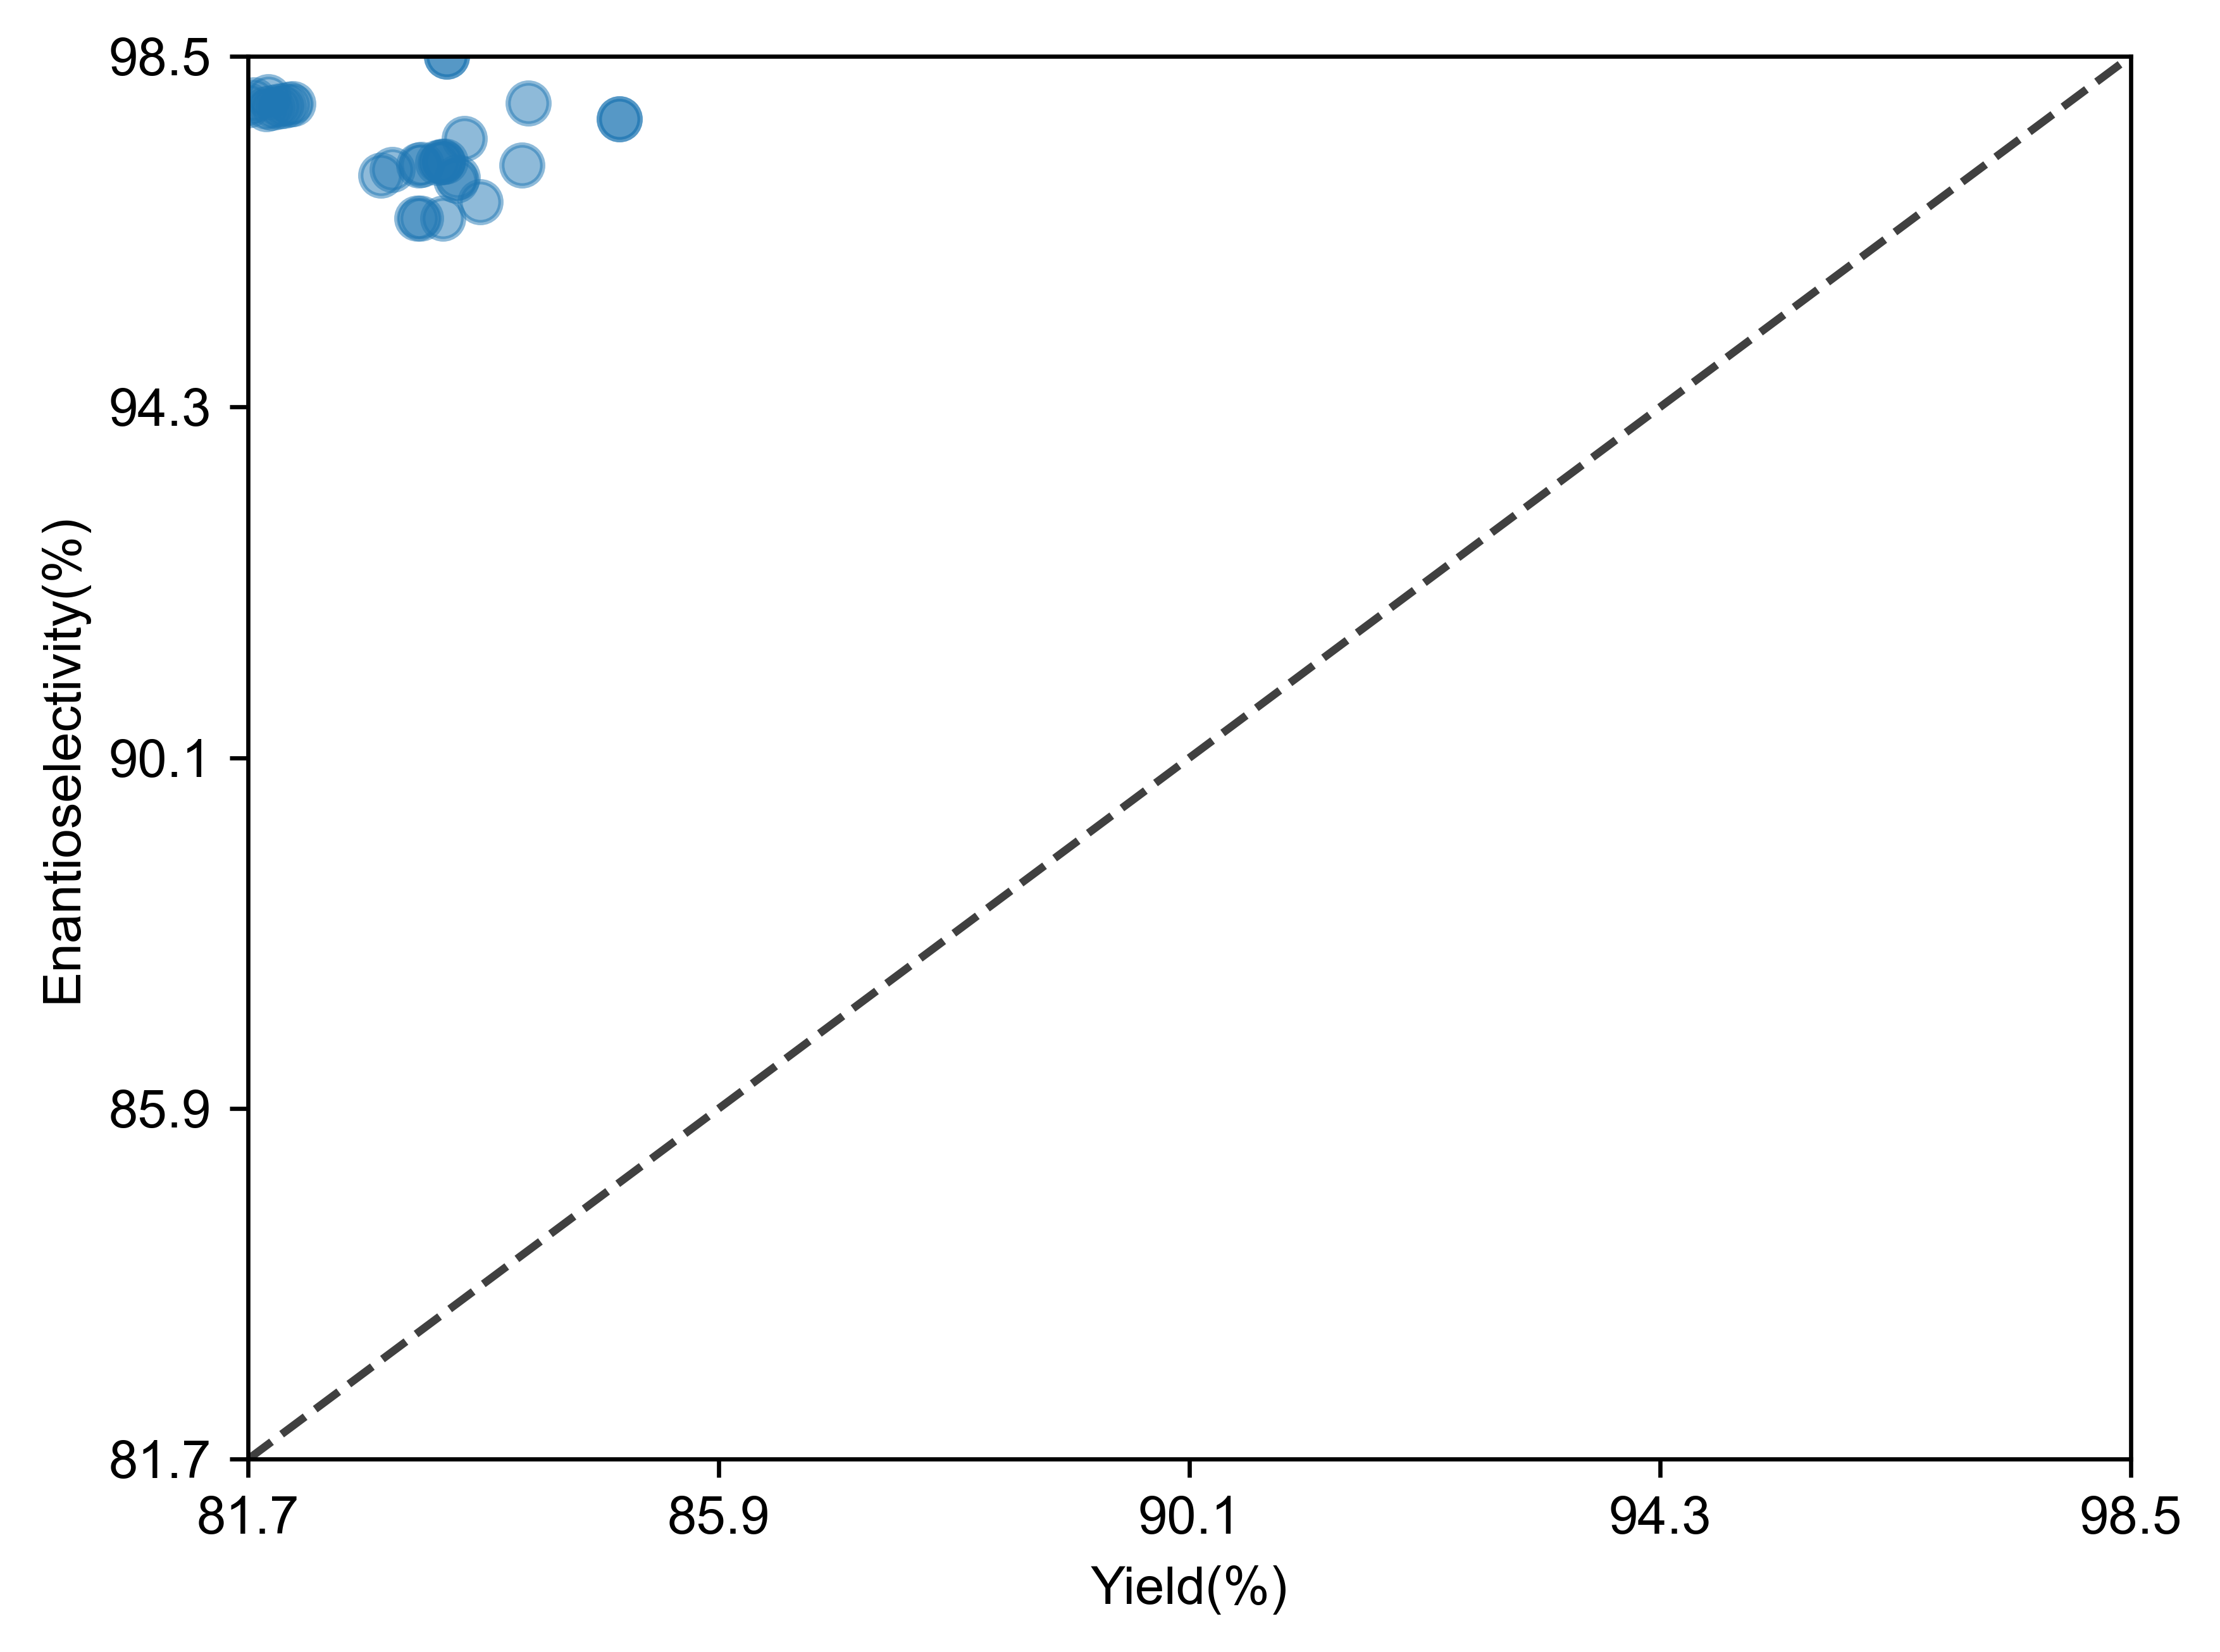

In [14]:
# %autoreload 2

display(data_opt.round(decimals=2))
data_opt.to_csv("outputs/optimization.csv", index=False)
# Make the pareto plots
plotting.pareto_front_exp(Exp_lhc, fill=False, dpi=600)